# Plate2Recipe Project


In [1]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd drive/MyDrive/CS7643_Team_Project/final_project/
!pip install -q datasets transformers
!pip install deeplake
!pip install transformers[torch]
!pip install -U accelerate
!pip install -U transformers
!pip install -I pillow==10.3.0


  Using cached pillow-10.3.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeplake 3.9.1 requires pillow~=10.2.0, but you have pillow 10.3.0 which is incompatible.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Notes:
# !pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:

# from datasets import load_dataset
# ds = load_dataset("imagefolder", data_dir="/data/food-101/images")
# ds = ds['train']
import deeplake
ds = deeplake.load('hub://activeloop/food-101-dataset-train')


|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/food-101-dataset-train



-

hub://activeloop/food-101-dataset-train loaded successfully.



In [4]:
ds.visualize()

HINT: Please forward the port - 51805 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


In [5]:
dataloader = ds.pytorch(num_workers=0, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [12]:
# data = dataloader.train_test_split(test_size=0.15)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

root_dir = './data/'

train_dataset = datasets.Food101(root=root_dir, split='train', transform=train_transforms, download=True)
valid_dataset = datasets.Food101(root=root_dir, split='test', transform=valid_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

100%|██████████| 4996278331/4996278331 [06:16<00:00, 13259443.06it/s]


Extracting ./data/food-101.tar.gz to ./data/


In [24]:
# Accessing the Food101 dataset from the public hub
from datasets import load_dataset
ds = load_dataset("food101")
ds = ds['train']

In [25]:
# randomly created a test split for validating the model
data = ds.train_test_split(test_size=0.15)

In [26]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 64387
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 11363
    })
})

In [31]:
# sample image
train = data['train']
ex = train[400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 62}

In [28]:
labels = data['train'].features['label']
labels

ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'mac

In [32]:
labels.int2str(ex['label'])

'macaroni_and_cheese'

In [33]:
# load the Accuracy metric, which we'll use to evaluate our model both during and after training.
from datasets import load_metric
metric = load_metric("accuracy")

<ipython-input-33-2d6dc6c64b8f>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [34]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [35]:
# create an id2label dictionary to decode them back to strings and see what they are
id2label

{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare',
 5: 'beet_salad',
 6: 'beignets',
 7: 'bibimbap',
 8: 'bread_pudding',
 9: 'breakfast_burrito',
 10: 'bruschetta',
 11: 'caesar_salad',
 12: 'cannoli',
 13: 'caprese_salad',
 14: 'carrot_cake',
 15: 'ceviche',
 16: 'cheesecake',
 17: 'cheese_plate',
 18: 'chicken_curry',
 19: 'chicken_quesadilla',
 20: 'chicken_wings',
 21: 'chocolate_cake',
 22: 'chocolate_mousse',
 23: 'churros',
 24: 'clam_chowder',
 25: 'club_sandwich',
 26: 'crab_cakes',
 27: 'creme_brulee',
 28: 'croque_madame',
 29: 'cup_cakes',
 30: 'deviled_eggs',
 31: 'donuts',
 32: 'dumplings',
 33: 'edamame',
 34: 'eggs_benedict',
 35: 'escargots',
 36: 'falafel',
 37: 'filet_mignon',
 38: 'fish_and_chips',
 39: 'foie_gras',
 40: 'french_fries',
 41: 'french_onion_soup',
 42: 'french_toast',
 43: 'fried_calamari',
 44: 'fried_rice',
 45: 'frozen_yogurt',
 46: 'garlic_bread',
 47: 'gnocchi',
 48: 'greek_salad',
 49: 'grilled_chees

In [37]:
# load pretrained model
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [36]:
feature_extractor.size

{'height': 224, 'width': 224}

## Data Collection and Preprocessing


- Data loading: *use food-101.tar.gz for CNN and full_dataset.csv for NLP* (https://drive.google.com/drive/folders/1ui_zS11_ENZTCNLUsgg_UwAYr-ZaLbac)
- Data cleaning
- Data augmentation

In [22]:
# Before we can feed these images to our model
# we need to preprocess them.
# (1) resizing them to a particular size
# (2) normalizing the color channels (R,G,B) using a mean and standard deviation.
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((224, 224)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((224, 224)),
            CenterCrop((224, 224)),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [39]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [40]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [41]:
train_ds[0]

{'image': <PIL.Image.Image image mode=RGB size=512x384>,
 'label': 24,
 'pixel_values': tensor([[[-0.0118, -0.0275, -0.0510,  ...,  0.1294,  0.1294,  0.1216],
          [-0.0118, -0.0353, -0.0667,  ...,  0.1294,  0.1451,  0.1451],
          [-0.0353, -0.0431, -0.0510,  ...,  0.1216,  0.1373,  0.1451],
          ...,
          [-0.0745, -0.0824, -0.0745,  ...,  0.0588,  0.0510,  0.0510],
          [-0.0745, -0.0824, -0.0667,  ...,  0.0588,  0.0510,  0.0510],
          [-0.0745, -0.0667, -0.0588,  ...,  0.0667,  0.0588,  0.0588]],
 
         [[ 0.0667,  0.0588,  0.0275,  ...,  0.0588,  0.0745,  0.0667],
          [ 0.0588,  0.0353,  0.0039,  ...,  0.0588,  0.0745,  0.0745],
          [ 0.0431,  0.0196,  0.0039,  ...,  0.0510,  0.0667,  0.0745],
          ...,
          [-0.0039, -0.0196, -0.0275,  ...,  0.0667,  0.0667,  0.0667],
          [ 0.0039, -0.0039, -0.0196,  ...,  0.0745,  0.0667,  0.0667],
          [ 0.0118,  0.0039,  0.0039,  ...,  0.0824,  0.0745,  0.0745]],
 
         [[-0

In [68]:
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [42]:
# download the pretrained model and fine-tune it.
# Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes)
# at resolution 224x224.
# It was introduced in the paper An Image is Worth 16x16 Words:
# Transformers for Image Recognition at Scale
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
#  define the training configuration and the evaluation metric
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-food101',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

In [25]:
import numpy as np

#  define a function for how to compute the metrics from the predictions.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch

# to batch examples together. Each batch consists of 2 keys, namely pixel_values and labels.
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [73]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [74]:
# finetune our model by calling the train method:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


events.out.tfevents.1714194920.8eec29eb7fb6.22380.2:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

events.out.tfevents.1714194595.8eec29eb7fb6.22380.0:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

events.out.tfevents.1714195093.8eec29eb7fb6.22380.3:   0%|          | 0.00/402k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1714194870.8eec29eb7fb6.22380.1:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =           4.0
  total_flos               = 18603741848GF
  train_loss               =        0.9841
  train_runtime            =    5:05:51.29
  train_samples_per_second =        14.034
  train_steps_per_second   =         0.877


In [1]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "food-ingredient-classification",
    "dataset": 'food101',
    "tags": ['image-classification', 'food-ingredient-classification', 'food101', 'food101-finetuned'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

NameError: name 'model' is not defined

In [46]:
# load the model "your-username/the-name-you-picked" so for instance:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("ericmconnelly/finetuned-food101")
model = AutoModelForImageClassification.from_pretrained("ericmconnelly/finetuned-food101")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


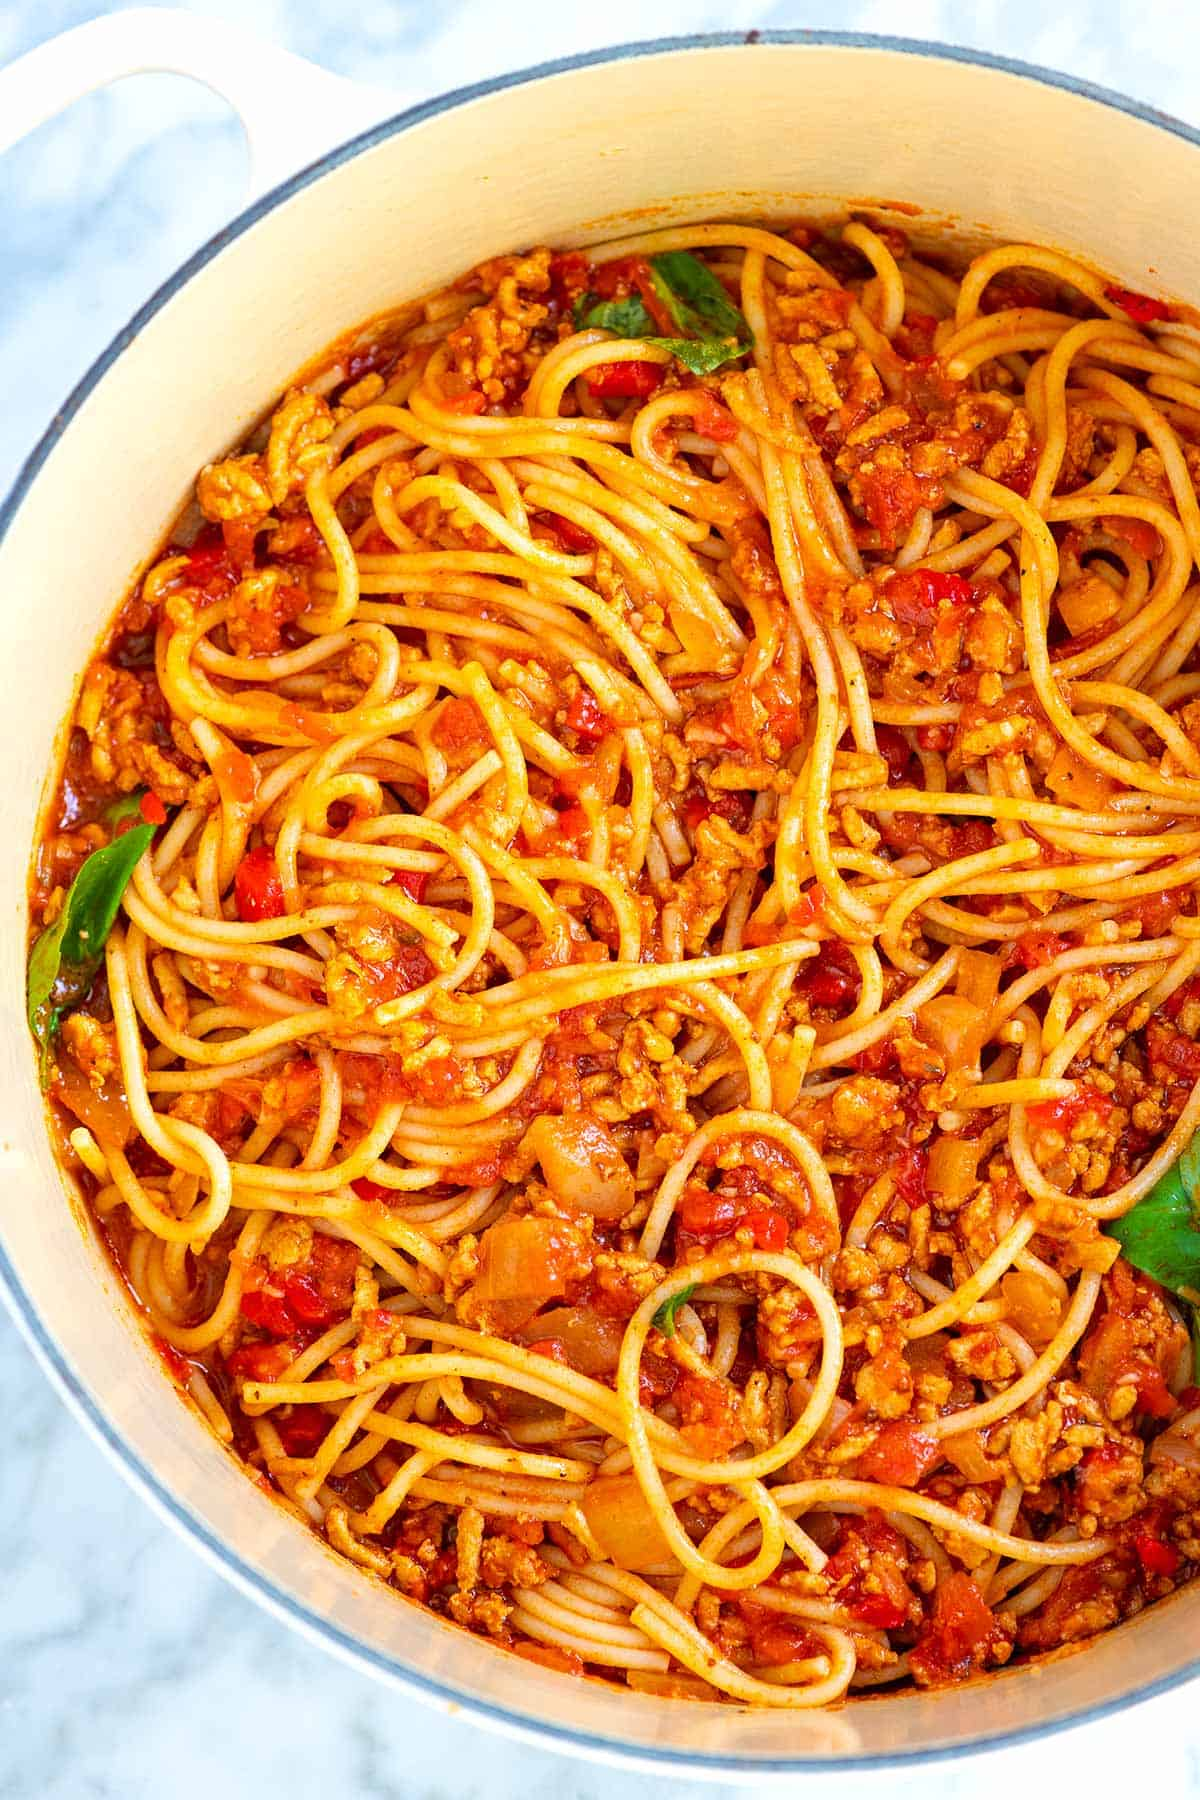

In [47]:
## INFERENCES

from PIL import Image
import requests

url = 'https://www.inspiredtaste.net/wp-content/uploads/2019/03/Spaghetti-with-Meat-Sauce-Recipe-3-1200.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image



In [48]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [49]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [50]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: spaghetti_bolognese


In [ ]:
# # CNN - Load and Transform Data

# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# valid_transforms = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# root_dir = './data/'

# train_dataset = datasets.Food101(root=root_dir, split='train', transform=train_transforms, download=True)
# valid_dataset = datasets.Food101(root=root_dir, split='test', transform=valid_transforms, download=True)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
# NLP - Load data

import pandas as pd

recipes = pd.read_csv('./data/full_dataset.csv', encoding='UTF-8')
recipes = recipes.drop(recipes.columns[0], axis=1)
recipes.head(20)

title  \
0                No-Bake Nut Cookies   
1              Jewell Ball'S Chicken   
2                        Creamy Corn   
3                      Chicken Funny   
4               Reeses Cups(Candy)     
5           Cheeseburger Potato Soup   
6                Rhubarb Coffee Cake   
7                     Scalloped Corn   
8               Nolan'S Pepper Steak   
9                    Millionaire Pie   
10             Double Cherry Delight   
11                     Buckeye Candy   
12              Quick Barbecue Wings   
13               Taco Salad Chip Dip   
14      Pink Stuff(Frozen Dessert)     
15              Fresh Strawberry Pie   
16        Easy German Chocolate Cake   
17                    Broccoli Salad   
18               Strawberry Whatever   
19  Eggless Milkless Applesauce Cake   

                                          ingredients  \
0   ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1   ["1 small jar chipped beef, cut up", "4 boned ...   
2   ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3   ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4   ["1 c. peanut butter", "3/4 c. graham cracker ...   
5   ["6 baking potatoes", "1 lb. of extra lean gro...   
6   ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...   
7   ["1 can cream-style corn", "1 can whole kernel...   
8   ["1 1/2 lb. round steak (1-inch thick), cut in...   
9   ["1 large container Cool Whip", "1 large can c...   
10  ["1 (17 oz.) can dark sweet pitted cherries", ...   
11  ["1 box powdered sugar", "8 oz. soft butter", ...   
12  ["chicken wings (as many as you need for dinne...   
13  ["8 oz. Ortega taco sauce", "8 oz. sour cream"...   
14  ["1 can pie filling (cherry or strawberry)", "...   
15  ["1 baked pie shell", "1 qt. cleaned strawberr...   
16  ["1/2 pkg. chocolate fudge cake mix without pu...   
17  ["1 large head broccoli (about 1 1/2 lb.)", "1...   
18  ["1 lb. frozen strawberries in juice", "1 smal...   
19  ["3/4 c. sugar", "1/2 c. shortening", "1 1/2 c...   

                                           directions  \
0   ["In a heavy 2-quart saucepan, mix brown sugar...   
1   ["Place chipped beef on bottom of baking dish....   
2   ["In a slow cooker, combine all ingredients. C...   
3   ["Boil and debone chicken.", "Put bite size pi...   
4   ["Combine first four ingredients and press in ...   
5   ["Wash potatoes; prick several times with a fo...   
6   ["Cream sugar and butter.", "Add egg and beat ...   
7   ["Mix together both cans of corn, crackers, eg...   
8   ["Roll steak strips in flour.", "Brown in skil...   
9   ["Empty Cool Whip into a bowl.", "Drain juice ...   
10  ["Drain cherries, measuring syrup.", "Cut cher...   
11  ["Mix sugar, butter and peanut butter.", "Roll...   
12  ["Clean wings.", "Flour and fry until done.", ...   
13  ["Mix taco sauce, sour cream and cream cheese....   
14  ["Mix all ingredients together.", "Pour into a...   
15  ["Mix water, cornstarch, sugar and salt in sau...   
16  ["Mix according to directions and add oil.", "...   
17  ["Trim off large leaves of broccoli and remove...   
18  ["Mix Jell-O in boiling water.", "Add strawber...   
19  ["Mix Crisco with applesauce, nuts and raisins...   

                                               link    source  \
0    www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1   www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2    www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3   www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4   www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   
5    www.cookbooks.com/Recipe-Details.aspx?id=20115  Gathered   
6   www.cookbooks.com/Recipe-Details.aspx?id=210288  Gathered   
7   www.cookbooks.com/Recipe-Details.aspx?id=876969  Gathered   
8   www.cookbooks.com/Recipe-Details.aspx?id=375254  Gathered   
9   www.cookbooks.com/Recipe-Details.aspx?id=794547  Gathered   
10  www.cookbooks.com/Recipe-Details.aspx?id=703381  Gathered   
11  www.cookbo

In [11]:
# %ls
# %cd ..
# %cd data
!python split_data.py

In [ ]:
# %cd ..
# !python split_data.py

/content/drive/MyDrive/CS7643_Team_Project/final_project
Creating train data...
Creating validation data...


## Model Development
- CNN for Image Processing
- NLP for Recipe Generation


### InversionVision Model
- Assume an input image, generate the list of ingredients from the image

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torchvision import transforms
from PIL import Image
import time
from tensorflow.keras.preprocessing import image
from utils import prepare_output

data_dir= './data/'

use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

t = time.time()
import sys; sys.argv=['']; del sys
args = {
    'save_dir': 'path/to/save/models',
    'project_name':'inversecooking',
    'model_name':'model',
    'transfer_from':'',
    'suff':'',
    'image_model':'resnet50',
    'recipe1m_dir':'path/to/recipe1m',
    'aux_data_dir':'../data',
    'crop_size':224,
    'image_size':256,
    'log_step':10,
    'learning_rate':0.001,
    'scale_learning_rate_cnn':0.01,
    'lr_decay_rate':0.99,
    'lr_decay_every':1,
    'weight_decay':0.0,
    'embed_size':512,
    'n_att':8,
    'n_att_ingrs':4,
    'transf_layers': 16,
    'transf_layers_ingrs': 4,
    'num_epochs': 400,
    'batch_size': 128,
    'num_workers': 8,
    'dropout_encoder': 0.3,
    'dropout_decoder_r': 0.3,
    'dropout_decoder_i':0.3,
    'finetune_after': -1,
    'loss_weight': [1.0, 0.0, 0.0, 0.0],
    'max_eval': 4096,
    'label_smoothing_ingr': 0.1,
    'patience':50,
    'maxseqlen':15,
    'maxnuminstrs':10,
    'maxnumims':5,
    'maxnumlabels':20,
    'es_metric':'loss',
    'eval_split':'val',
    'numgens': 3,
    'greedy': False,
    'temperature': 1.0,
    'beam': -1,
    'ingrs_only':False,
    'recipe_only': False,
    'log_term': False,
    'tensorboard': True,
    'resume': False,
    'decay_lr': True,
    'use_lmdb': True,
    'get_perplexity': False,
    'use_true_ingrs': False
}


from model import get_model
model=get_model(args, ingr_vocab_size, instrs_vocab_size)

# Load the pre-trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False

transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406),
                                            (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

greedy = [True, False]
beam = [-1, -1]
temperature = 1.0
numgens = len(greedy)
img=image.load_img(data_dir + 'food-101/images/caprese_salad/3658.jpg')

show_anyways = True
transf_list = []
transf_list.append(transforms.Resize(256))
transf_list.append(transforms.CenterCrop(224))
transform = transforms.Compose(transf_list)

image_transf = transform(img)
image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

num_valid = 1
title=[]
ingredients=[]
recipe=[]
for i in range(numgens):
    with torch.no_grad():
        outputs = model.sample(image_tensor, greedy=greedy[i],
                            temperature=temperature, beam=beam[i], true_ingrs=None)

    ingr_ids = outputs['ingr_ids'].cpu().numpy()
    recipe_ids = outputs['recipe_ids'].cpu().numpy()

    outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

    if valid['is_valid'] or show_anyways:
        title.append(outs['title'])
        ingredients.append(outs['ingrs'])
        recipe.append(outs['recipe'])
    else:
        title.append("Invalid recipe")

print('title ', title)
print('ingredients ', ingredients)
print('recipe ', recipe)



/Users/ericconnelly/miniconda3/envs/p2r/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericconnelly/miniconda3/envs/p2r/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericconnelly/miniconda3/envs/p2r/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


title  ['Caprese salad', 'Caprese sandwich']
ingredients  [['tomato', 'pepper', 'oil', 'basil', 'cheese', 'bread', 'vinegar'], ['tomato', 'pepper', 'oil', 'basil', 'cheese', 'bread', 'vinegar']]
recipe  [['Slice tomatoes and mozzarella uniformly.', 'Arrange on a plate.', 'Sprinkle with salt and pepper.', 'Drizzle with olive oil and balsamic vinegar.', 'Top with basil leaves.'], ['Slice cheese and tomatoes.', 'Lay bread slices on baking sheet.', 'Spread olive oil and balsamic vinegar in a bowl.', 'Season with salt and pepper.', 'Arrange mozzarella and tomato slices on the bread.', 'Top with basil leaves.', 'Bake sandwiches in a preheated oven at 200 degrees f for about 10 minutes or until cheese is melted and bread is toasted.']]


In [ ]:
%python train.py

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


### NLP Model
- Assume list of ingredients is provided, we can use this to generate the recipe.
- Match input list of ingredients with the ingredients in the dataset and generate the recipe
- Approaches:
        -- Best Matching using Cosine Similarity: The chosen recipe will be the one with the highest similarity score
        -- GPT2 model
        -- ...

In [ ]:
# Assume 'user_ingredients' list is already defined
# user_ingredients = ['chicken', 'onion', 'pepper']
user_ingredients = ingredients[0]

- #### Using TF-IDF for vectorization & cosine similarity for best matching

In [ ]:
# using TF-IDF for vectorization and cosine similarity for matching

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Preprocess data:
def preprocess(ingredients):
    return [' '.join(eval(ing)).lower().replace('[^a-z\s]', '') for ing in ingredients]

# VECTORIZE
vectorizer = TfidfVectorizer()

# Vectorize ingredients:
recipe_ingredients = preprocess(recipes['NER'])
recipe_tfidf = vectorizer.fit_transform(recipe_ingredients)

# Vectorize user ingredients:
user_ingredients_string = ' '.join(user_ingredients).lower()
user_tfidf = vectorizer.transform([user_ingredients_string])


# COMPUTE COSINE SIMILARITY
similarity_scores = cosine_similarity(user_tfidf, recipe_tfidf)

# Select the best matching recipe
best_match_index = similarity_scores.argmax()
best_recipe = recipes.iloc[best_match_index]

print("Best Matching Recipe:", best_recipe['title'])
print("Ingredients:", best_recipe['ingredients'])
print("Directions:", best_recipe['directions'])

Best Matching Recipe: Basil Brie Toast Recipe
Ingredients: ["2 c. Basil leaves, fresh", "1/2 c. Pine nuts", "3 x Garlic, cloves, chopped", "1/4 tsp Salt", "1/2 c. Oil, olive", "1/3 c. Cheese, Parmesan, fresh, Grated", "8 x Bread, white or possibly whole wheat, Cut in half, crusts removed", "3/4 lb Cheese, Brie, sliced thin, Thick parts of rind trimmed Off Margarine or possibly butter, melted, For brushing on grill rack", "1 x Tomato, sliced for garnish", "1 x Basil leaves, fresh for Garnish"]
Directions: ["For pesto sauce, put basil, pine nuts, garlic and salt in a blender or possibly food processor fitted with steel blade.", "process till pureed.", "With the machine running, pour oil in a slow, steady stream.", "Process till sauce is smooth.", "spoon sauce into a bowl.", "Add in parmesan cheese.", "Mix well.", "Cover and chill.", "Cover bread with slices of Brie cheese.", "Spread top of cheese with a thin layer of pesto sauce.", "Prepare grill.", "When coals are warm, place bread on g

- #### Using GPT-2:
This approach combines traditional NLP techniques for ingredient matching with advanced language generation capabilities of GPT-2


In [ ]:
# Use GPT-2 to generate a Recipe

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load pre-trained model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Input Text to GPT-2: provide context to GPT-2 for generating the recipe. The format & content can be adjusted based on how we want GPT-2 to expand the recipe information.
text = f"Ingredients: {', '.join(user_ingredients)}; Recipe: {best_recipe['title']} - Directions:"

# Encode the text input
indexed_tokens = tokenizer.encode(text, add_special_tokens=True)
tokens_tensor = torch.tensor([indexed_tokens])

# Generate a text using the model
model.eval()
with torch.no_grad():
    outputs = model.generate(tokens_tensor, max_length=300, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Ingredients: tomato, pepper, oil, basil, cheese, bread, vinegar; Recipe: Basil Brie Toast Recipe - Directions: Preheat oven to 350 degrees F. Line a baking sheet with parchment paper and set aside. In a large bowl, whisk together the flour, baking powder, salt, and pepper. Add the onion and cook, stirring occasionally, until soft and translucent, about 5 minutes. Remove from the heat and allow to cool slightly. Transfer to a wire rack and refrigerate until ready to use.

Recipe Notes: For this recipe, I used 1/4 cup of olive oil. If you don't have it, you can use 1 tablespoon of butter, but if you do, it's best to leave it in the fridge for at least 2 hours before using.


## Training
- Model compilation
- Model training
- Hyperparameter tuning

## Evaluation
- Model evaluation metrics
- Visualization of results

## Conclusion
- Summary of findings
- Future work